# Unstructured Synthetic Comparison

In [1]:
import Random
import JLD
import Distributions; distr = Distributions
import PyPlot; plt = PyPlot
import CMF; cmf = CMF
sep = CMF.Separable

include("../datasets/sep.jl")

Random.seed!(0);

┌ Info: Recompiling stale cache file /home/anthony/.julia/compiled/v1.1/CMF/0J4Dr.ji for CMF [db662885-8e4b-5931-925d-197754c06cb4]
└ @ Base loading.jl:1184
┌ Warning: Package CMF does not have WAV in its dependencies:
│ - If you have CMF checked out for development and have
│   added WAV as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CMF
└ Loading WAV into CMF from project dependency, future warnings for CMF are suppressed.


## Construct data

In [30]:
N, T, K, L = 100, 250, 3, 5
n_tests = 10
n_noise_levels = 13
noise_start = -3
noise_stop = 3

alg_dict = Dict(
    "Sep" => Dict(:alg => :sep),
    "Mult" => Dict(:alg => :mult, :max_time => 5, :max_itr => Inf),
    "HALS" => Dict(:alg => :hals, :max_time => 5, :max_itr => Inf),
    "SepSpec" => Dict(:alg => :sep, :spectral => true),
    "SepHALS" => Dict(:sep_init => true, :spectral => true,
                      :alg => :hals, :max_time => 5, :max_itr => Inf),
    "SepMult" => Dict(:sep_init => true, :spectral => true,
                      :alg => :mult, :max_time => 5, :max_itr => Inf)
)


noise_levels = exp10.(range(noise_start, stop=noise_stop, length=n_noise_levels))
noise_types = Dict(
    :uniform => (data, e) -> data + rand(distr.Uniform(0, e), N, T),
    :gaussian => (data, e) -> max.(0, data + rand(distr.Normal(0, e), N, T)),
    :exponential => (data, e) -> data + rand(distr.Exponential(e), N, T)
)
noise_labels = Dict(
    :uniform => "Unif",
    :gaussian => "Gauss",
    :exponential => "Exp",
);

In [3]:
# Random.seed!(0)
data_arr = []

for j in 1:n_tests
    push!(data_arr, gen_sep_data(N, T, K, L))
end

## Fit data

In [32]:
#results = Dict()  # noise type -- noise level -- trial -- algorithm

for e_type in keys(noise_types)    
    for e in noise_levels
        for j in 1:n_tests
            data, tW, tH = data_arr[j]
            noisy_data = noise_types[e_type](data, e)
            
            for alg in ["SepMult"]  #keys(alg_dict)
                r = cmf.fit_cnmf(
                    noisy_data;
                    K=K, L=L,
                    thresh=max(0.25*N - e, 0),
                    #seed=0
                    alg_dict[alg]...
                )
                
                results[string(e_type, e, j, alg)] = r
            end
        end
    end
end

In [37]:
JLD.save("./sep_unstructured.jld", results)

## Generate statistics

In [4]:
results = JLD.load("./sep_unstructured.jld");

In [33]:
scores = Dict()
losses = Dict()

for e_type in keys(noise_types)
    for alg in keys(alg_dict)
        scores[e_type, alg] = zeros(n_noise_levels)
        losses[e_type, alg] = zeros(n_noise_levels)
        
        for j in 1:n_tests
            data, tW, tH = data_arr[j]

            for (i, e) in Iterators.enumerate(noise_levels)
                r = results[string(e_type, e, j, alg)]
                perm = sep.permute_factors(tH, r.H)
                scores[e_type, alg][i] += sep.cos_score(r.H[perm, :], tH)
                losses[e_type, alg][i] += cmf.compute_loss(r.data, r.W, r.H)
            end
        end
        
        scores[e_type, alg] = scores[e_type, alg] / n_tests
        losses[e_type, alg] = losses[e_type, alg] / n_tests
    end
end
;

## Generate figures

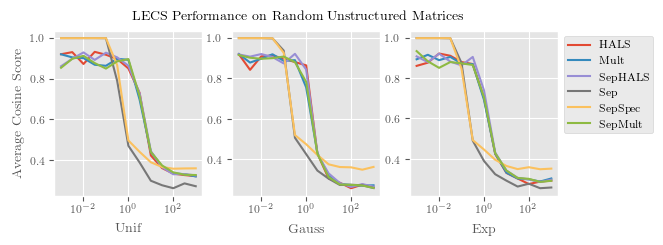

In [36]:
include("./sep_plot_settings.jl")

fig, axes = plt.subplots(1, 3, figsize=set_size(doc_textwidth, aspect=0.33))

for (i, e_type) in Iterators.enumerate(keys(noise_types))
    ax = axes[i]
    for alg in keys(alg_dict)
        ax.plot(noise_levels, scores[e_type, alg], label=alg, markersize=0)
    end
    
    ax.set_xscale("log")
    ax.set_xlabel(noise_labels[e_type])
end

fig.suptitle("LECS Performance on Random Unstructured Matrices")
axes[3].legend(bbox_to_anchor=(1, 1))
axes[1].set_ylabel("Average Cosine Score")
plt.show()

plt.savefig("./sep_unstructured.pdf")